# Spoken Digit Challenge

This is the first challenge of our Speech and Machine Learning Workshop. Here we will use the [FSDD][] Free Spoken Digit Dataset to build different models and recognize the digits from speech.   

** Note: ** Make sure that your dataset is in the correct folder - if there´s something not working for you, feel free to ask.

* 1500 recordings in total (150 per digit)
* 8kHz sampling rate
* 3 speakers
* English 
* File format: {digit\_label}\_{speaker\_name}\_{index}.wav <br> (e.g. "4\_jackson\_16.wav")

[FSDD]: https://github.com/Jakobovski/free-spoken-digit-dataset  

## Feature Extraction

First, we will extract our features from the audio files. Two files will be generated - one for the features and one for the corresponding labels. Each line in our feature-label-pair will represent a single audio file.

In [2]:
# Import the relevant modules to be used later
import glob
import os
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram



# Config matplotlib for inline plotting
%matplotlib inline

In [3]:
# Dataset directory
DATASET_DIR = "dataset/"

# Create a list of all .wav files in the dataset directoy paths 
sound_paths = [DATASET_DIR + f for f in os.listdir(DATASET_DIR) if f[-4:] == '.wav' and 'jackson' in f]

In [4]:
def load_sound_files(file_paths):
    return [librosa.load(fp)[0] for fp in file_paths]

def plot_wave(sound_name_with_raw_data):
    i = 1
    plt.figure(figsize=(15, 2 * len(sound_name_with_raw_data) if len(sound_name_with_raw_data) > 1 else 4))
    for n,d in sound_name_with_raw_data:
        plt.subplot(np.ceil(float(len(sound_name_with_raw_data))/2), 2, i)
        
        # wave plot
        librosa.display.waveplot(np.array(d),sr=8000)
        
        plt.ylabel('Amplitude')
        plt.title(n)
        i += 1
    plt.subplots_adjust(top=0.8, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()
    
def plot_spectrogram(sound_name_with_raw_data):
    i = 1
    plt.figure(figsize=(15, 2 * len(sound_name_with_raw_data) if len(sound_name_with_raw_data) > 1 else 4))
    for n,d in sound_name_with_raw_data:
        plt.subplot(np.ceil(float(len(sound_name_with_raw_data))/2), 2, i)
        
        # Spectrogram
        specgram(np.array(d), Fs=8000, NFFT=512, noverlap=248, scale="dB", vmax=20)
        
        plt.title(n)
        i += 1
    plt.subplots_adjust(top=0.8, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

In [5]:
# Target sound filenames for visualization
sound_filenames = [str(i) + '_jackson_0.wav' for i in range(0, 10)]

# Load sound files used in visualization
sound_name_with_raw_data = [("Digit " + os.path.basename(p)[0], librosa.load(p)[0]) for i, p in enumerate(sound_paths) if os.path.basename(p) in sound_filenames]

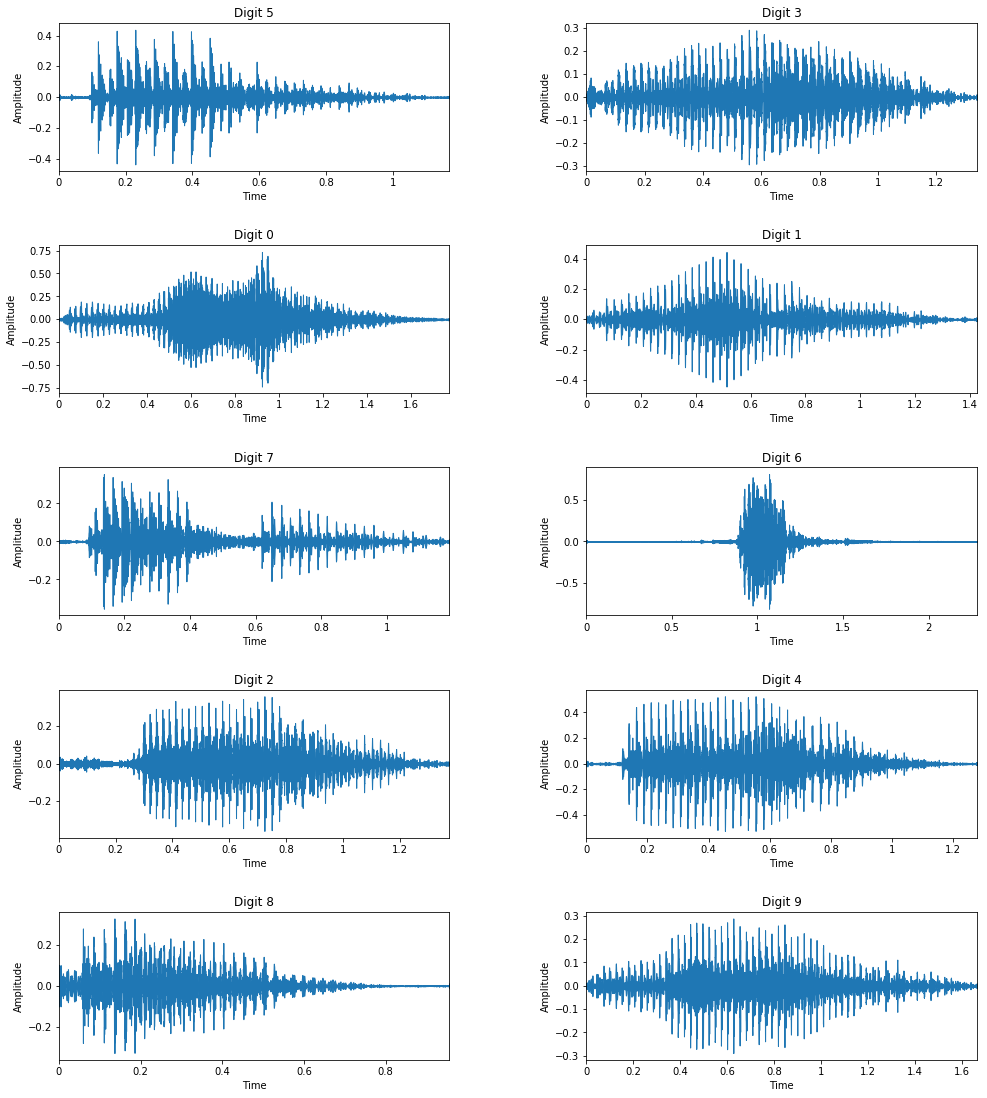

In [6]:
plot_wave(sound_name_with_raw_data)

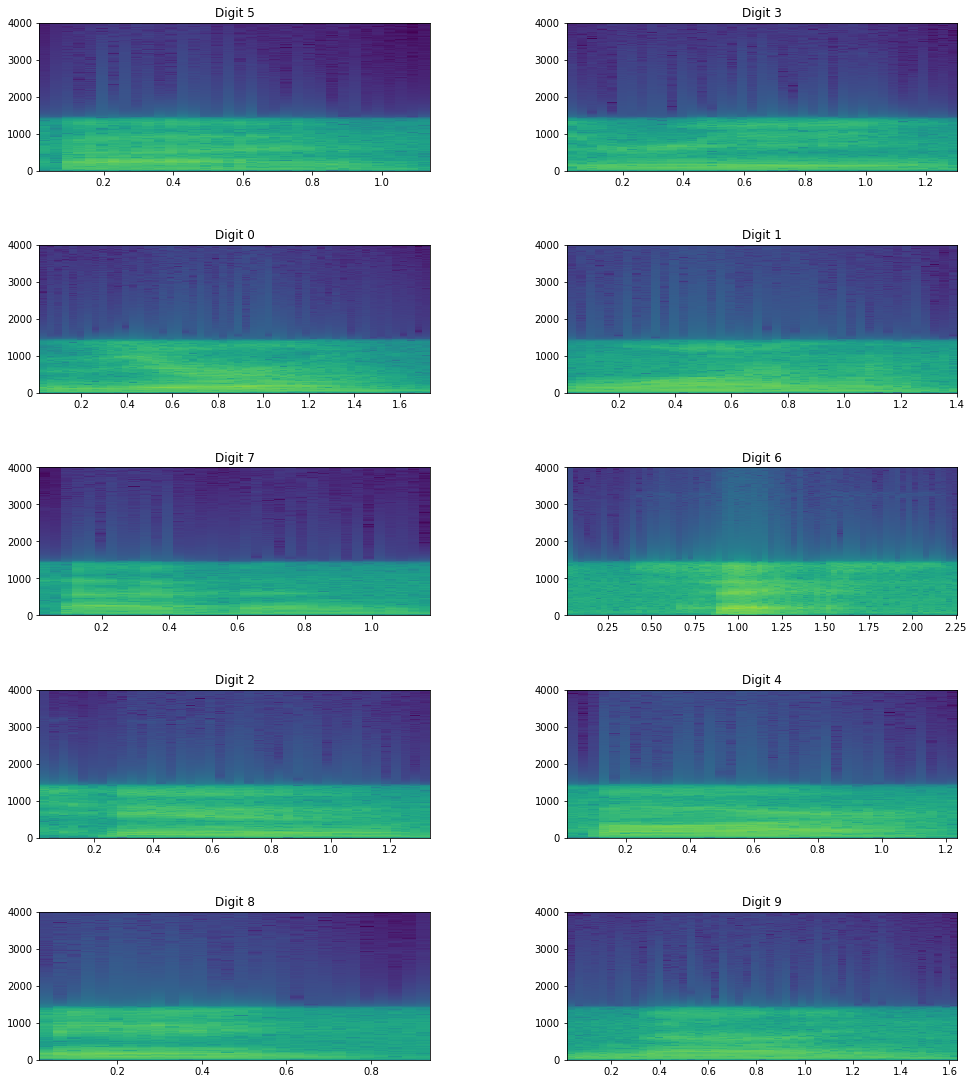

In [7]:
plot_spectrogram(sound_name_with_raw_data)

In [8]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def get_features_and_labels(sound_paths):
    features, labels = np.empty((0,193)), np.empty(0)
    for p in sound_paths:
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(p)
        ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        features = np.vstack([features,ext_features])
        labels = np.append(labels, int(os.path.basename(p)[0]))
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [9]:
features, labels = get_features_and_labels(sound_paths)
labels = one_hot_encode(labels)

In [10]:
FEATURE_PATH = 'features/features.txt'
LABEL_PATH = 'features/labels.txt'

In [12]:
np.savetxt(FEATURE_PATH, features, fmt='%10.5f', delimiter='\t')
np.savetxt(LABEL_PATH, labels, fmt='%i', delimiter='\t')

## Classification

Now, we will load our generated features and labels in order to train a classifier on it and evaluate its performance

In [14]:
import random
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.initializers import lecun_uniform
from keras import optimizers
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_fscore_support)

/home/max/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
features = np.loadtxt(FEATURE_PATH)
labels = np.loadtxt(LABEL_PATH)

print('Label shape: ' + str(labels.shape))
feature_dim = features.shape[1]
print('Feature dimensions: ' + str(feature_dim))

Label shape: (500, 10)
Feature dimensions: 193


In [16]:

def split_train_test_eval (features, labels, train_percentage, test_percentage, eval_percentage):
    feature_label_pairs = list(zip(features, labels))
    random.shuffle(feature_label_pairs)
    features, labels = zip(*feature_label_pairs)
    features = np.array(features)
    labels = np.array(labels)
    
    sample_size = len(labels)
    print('Number of total samples: ' + str(sample_size))
    
    train_samples = int(sample_size * train_percentage)
    test_samples = int(sample_size * test_percentage)
    eval_samples = int(sample_size * eval_percentage)
    
    # just to make sure that we end up with the actual sample size:
    if train_samples + test_samples + eval_samples > sample_size:
        eval_samples = sample_size - train_samples - test_samples
    
    print('Train sample size: ' + str(train_samples))
    print('Test sample size: ' + str(test_samples))
    print('Eval sample size: ' + str(eval_samples))
    
    train_features = features[0 : train_samples]
    train_labels = labels[0 : train_samples]
    
    test_features = features[train_samples : train_samples + test_samples]
    test_labels = labels[train_samples : train_samples + test_samples]
    
    eval_features = features[train_samples + test_samples : train_samples + test_samples + eval_samples]
    eval_labels = labels[train_samples + test_samples : train_samples + test_samples + eval_samples]
    
    return train_features, train_labels, test_features, test_labels, eval_features, eval_labels
        
train_features, train_labels, test_features, test_labels, eval_features, eval_labels = split_train_test_eval (features, labels, 0.5, 0.3, 0.2)
    
evaluation = (eval_features, eval_labels)

Number of total samples: 500
Train sample size: 250
Test sample size: 150
Eval sample size: 100


### Building our model

In [24]:
model = Sequential()
model.add(Dense(units=300, input_dim=feature_dim, activation="relu"))
model.add(Dense(units=300,activation="relu"))
model.add(Dense(units=50, activation="relu"))
model.add(Dense(units=10,activation="sigmoid"))

opt = optimizers.Adam()
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

model.fit(train_features,train_labels, validation_data=evaluation, epochs=100, batch_size=8)

MODEL_DIR = "models/model1.model"

model.save(MODEL_DIR)

Train on 250 samples, validate on 100 samples
Epoch 1/100
250/250 [==============================] - 0s 2ms/step - loss: 0.8139 - acc: 0.8736 - val_loss: 0.7339 - val_acc: 0.8620
Epoch 2/100
250/250 [==============================] - 0s 356us/step - loss: 0.4567 - acc: 0.9060 - val_loss: 0.3722 - val_acc: 0.9140
Epoch 3/100
250/250 [==============================] - 0s 360us/step - loss: 0.2192 - acc: 0.9296 - val_loss: 0.1451 - val_acc: 0.9490
Epoch 4/100
250/250 [==============================] - 0s 382us/step - loss: 0.0863 - acc: 0.9664 - val_loss: 0.1012 - val_acc: 0.9600
Epoch 5/100
250/250 [==============================] - 0s 386us/step - loss: 0.0773 - acc: 0.9700 - val_loss: 0.1183 - val_acc: 0.9600
Epoch 6/100
250/250 [==============================] - 0s 381us/step - loss: 0.1449 - acc: 0.9552 - val_loss: 0.0762 - val_acc: 0.9730
Epoch 7/100
250/250 [==============================] - 0s 378us/step - loss: 0.0412 - acc: 0.9844 - val_loss: 0.0869 - val_acc: 0.9740
Epoch 8/100

Epoch 60/100
250/250 [==============================] - 0s 406us/step - loss: 1.3179e-04 - acc: 1.0000 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 61/100
250/250 [==============================] - 0s 365us/step - loss: 1.3570e-04 - acc: 1.0000 - val_loss: 0.0220 - val_acc: 0.9960
Epoch 62/100
250/250 [==============================] - 0s 359us/step - loss: 1.2272e-04 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9950
Epoch 63/100
250/250 [==============================] - 0s 373us/step - loss: 1.2188e-04 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 0.9950
Epoch 64/100
250/250 [==============================] - 0s 378us/step - loss: 1.2020e-04 - acc: 1.0000 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 65/100
250/250 [==============================] - 0s 363us/step - loss: 1.1069e-04 - acc: 1.0000 - val_loss: 0.0216 - val_acc: 0.9950
Epoch 66/100
250/250 [==============================] - 0s 600us/step - loss: 1.1259e-04 - acc: 1.0000 - val_loss: 0.0221 - val_acc: 0.9960
Epoch 67/100
250/250

In [25]:
prediction_probabilities = np.array(model.predict_proba(test_features))
prediction = np.array(model.predict_classes(test_features))
                                            
test_classes = np.argmax(test_labels, axis=1)
print(prediction)
print(test_classes)

accuracy = accuracy_score(test_classes, prediction)
print('Accuracy: ' + str(accuracy))

conf_mat = confusion_matrix(test_classes, prediction)
print(conf_mat)

[5 1 8 0 7 9 5 0 9 0 8 1 6 6 9 6 2 5 1 0 0 1 0 3 8 8 5 5 7 4 4 0 9 1 3 0 4
 6 3 9 9 4 9 4 4 6 0 8 4 0 6 5 1 7 2 5 3 0 2 9 9 3 5 3 8 6 4 2 7 3 8 7 2 9
 6 1 7 2 2 4 4 7 8 5 5 2 6 3 3 9 8 2 5 8 7 0 1 4 3 6 9 4 3 2 7 7 1 6 2 3 8
 5 0 7 3 5 1 6 2 2 8 3 5 3 0 9 7 4 2 1 8 5 4 4 6 0 1 6 0 4 8 8 7 0 2 4 5 0
 5 1]
[5 1 8 0 7 9 5 0 9 0 8 1 6 6 9 6 2 5 1 0 0 1 0 3 8 8 5 5 7 4 4 0 9 1 3 0 4
 6 3 2 9 4 9 4 4 6 0 8 1 0 6 5 1 7 2 5 3 0 2 9 9 3 5 3 8 6 4 2 7 3 8 7 2 9
 6 1 7 2 2 4 4 7 8 5 5 2 6 3 3 9 8 2 5 8 7 0 1 4 3 6 9 4 3 2 7 7 1 6 2 3 8
 5 0 7 3 5 1 6 2 2 8 3 5 3 0 9 7 4 2 1 8 5 1 4 0 0 1 6 0 4 8 8 7 0 2 4 5 0
 5 1]
Accuracy: 0.9733333333333334
[[18  0  0  0  0  0  1  0  0  0]
 [ 0 13  0  0  2  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  1]
 [ 0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  0  0 12]]
